In [ ]:
#@title Installation
!pip install timm foolbox

     |████████████████████████████████| 296kB 13.6MB/s 
     |████████████████████████████████| 1.7MB 28.0MB/s 
     |████████████████████████████████| 163kB 54.5MB/s 
     |████████████████████████████████| 61kB 8.8MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
#@title Mount Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#@title Imports

import eagerpy as ep
from foolbox import PyTorchModel, accuracy, samples
from foolbox.attacks import L2PGD

import timm

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

from tqdm import tqdm

import cv2

import matplotlib.pyplot as plt

PyTorch Version:  1.8.1+cu101
Torchvision Version:  0.9.1+cu101


In [ ]:
#@title Global Variables

clean_data_dir = "/content/drive/MyDrive/598dataset/tinyImageNet/TinyImageNet"
vit_weight_path = "/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes.pth"

# Number of classes in the dataset
num_classes = 16

# Batch size for training (change depending on how much memory you have)
batch_size = 32

input_size = 224

In [ ]:
#@title Model Init

# create model from timm and change last layer
model_ft = timm.create_model('vit_base_patch16_224', pretrained=True)
num_ftrs = model_ft.head.in_features
model_ft.head = nn.Linear(num_ftrs, num_classes)
print(model_ft)

# load weight
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/598dataset/ViTbase_16_224_tiny_15classes.pth'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model_ft = model_ft.to(device)
model_ft.eval()

# fool box model
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis=-3)
fmodel = PyTorchModel(model_ft, bounds=(0, 1), preprocessing=preprocessing)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-vitjx/jx_vit_base_p16_224-80ecf9dd.pth" to /root/.cache/torch/hub/checkpoints/jx_vit_base_p16_224-80ecf9dd.pth


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (

In [ ]:
#@title Dataloader Init
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(clean_data_dir, "tiny_"+x),
                                          transform[x])
                  for x in ['train', 'val']}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=False, num_workers=0, pin_memory=True)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [ ]:
#@title Utils
def generate_spectra(img): 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # substract median blur 
  img2 = img - cv2.medianBlur(img, 3)

  # Fourier Transform
  f = np.fft.fft2(img2)
  fshift = np.fft.fftshift(f)

  magnitude_spectrum = 20*np.log10(np.abs(fshift))
  
  return magnitude_spectrum


def generate_spectra_low(img): 
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # substract median blur 
  img2 = cv2.medianBlur(img, 3)

  # Fourier Transform
  f = np.fft.fft2(img2)
  fshift = np.fft.fftshift(f)

  magnitude_spectrum = 20*np.log10(np.abs(fshift))
  
  return magnitude_spectrum

def generate_spectra_raw(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Fourier Transform
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)

  magnitude_spectrum = 20*np.log(np.abs(fshift))
  
  return magnitude_spectrum


def average_spectra(images): 

  spectra_sum = np.zeros((224,224))
  
  for img in tqdm(images): 
    spectra = generate_spectra(img)
    spectra_sum = spectra_sum + spectra 
  return spectra_sum / len(images)

def average_spectra_low(images): 

  spectra_sum = np.zeros((224,224))
  
  for img in tqdm(images): 
    spectra = generate_spectra_low(img)
    spectra_sum = spectra_sum + spectra 
  return spectra_sum / len(images)

def average_spectra_raw(images):
  spectra_sum = np.zeros((224,224))
  
  for img in tqdm(images): 
    spectra = generate_spectra_raw(img)
    spectra_sum = spectra_sum + spectra 
  return spectra_sum / len(images)

  1%|▏         | 20/1600 [00:00<00:08, 193.05it/s]

L2 norm ≤ 0.5   : 18.4 %


100%|██████████| 1600/1600 [00:08<00:00, 188.49it/s]


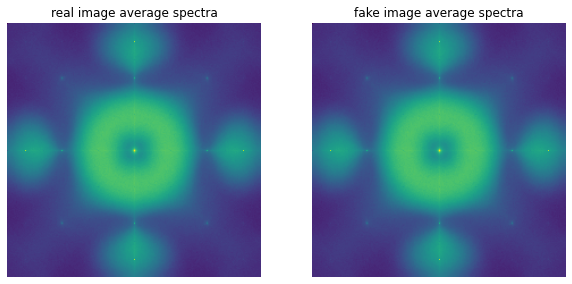

In [ ]:
#@title Attack Experiment High pass L2PGD 0.5
attack = L2PGD()
epsilons = [0.5]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.0325777685769566


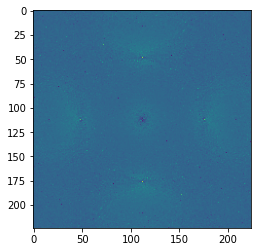

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 25/1600 [00:00<00:06, 246.08it/s]

L2 norm ≤ 1     : 12.8 %


100%|██████████| 1600/1600 [00:06<00:00, 244.53it/s]


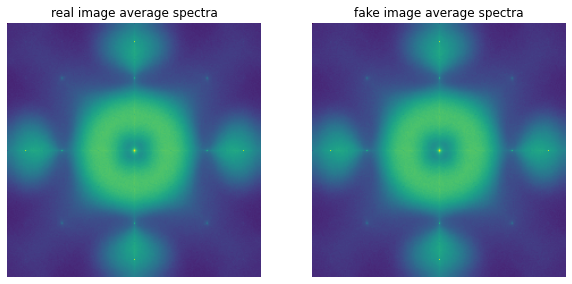

In [ ]:
#@title Attack Experiment L2PGD 1
attack = L2PGD()
epsilons = [1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('clean images average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('adversarial images average spectra')
ax[1].imshow(adv_spectra)

1.0292698591572744


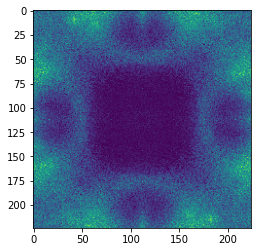

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  1%|▏         | 20/1600 [00:00<00:08, 196.95it/s]

L2 norm ≤ 2     :  1.3 %


100%|██████████| 1600/1600 [00:06<00:00, 247.26it/s]


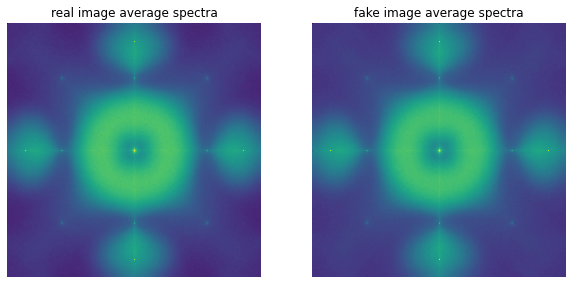

In [ ]:
#@title Attack Experiment L2PGD 2
attack = L2PGD()
epsilons = [2]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('clean images average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('adversarial images average spectra')
ax[1].imshow(adv_spectra)

2.7206192415755197


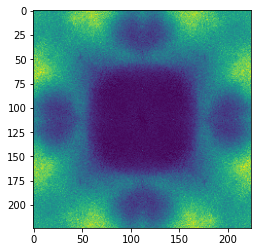

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 25/1600 [00:00<00:06, 242.26it/s]

L2 norm ≤ 0.1   : 14.2 %


100%|██████████| 1600/1600 [00:06<00:00, 247.03it/s]


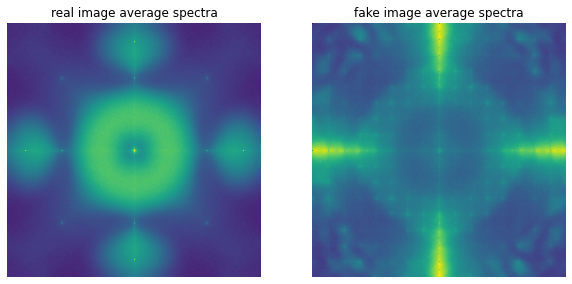

In [ ]:
#@title Attack Experiment LinfFGSM 0.1
from foolbox.attacks import LinfFastGradientAttack

attack = LinfFastGradientAttack()
epsilons = [0.1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

23.326579862708954


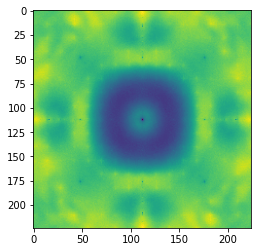

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 26/1600 [00:00<00:06, 250.89it/s]

L2 norm ≤ 0.01  : 26.1 %


100%|██████████| 1600/1600 [00:06<00:00, 246.50it/s]


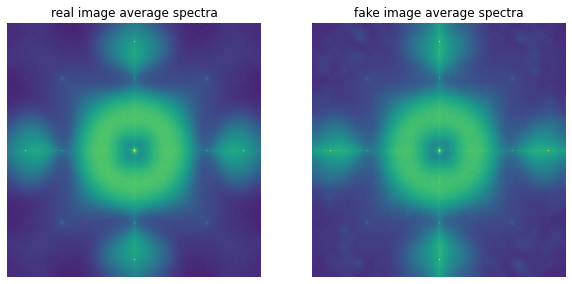

In [ ]:
#@title Attack Experiment LinfFGSM 0.01
from foolbox.attacks import LinfFastGradientAttack

attack = LinfFastGradientAttack()
epsilons = [0.01]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

4.7144924755892035


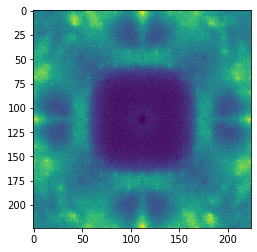

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  1%|▏         | 20/1600 [00:00<00:08, 194.75it/s]

L2 norm ≤ 1     :  2.2 %


100%|██████████| 1600/1600 [00:06<00:00, 241.20it/s]


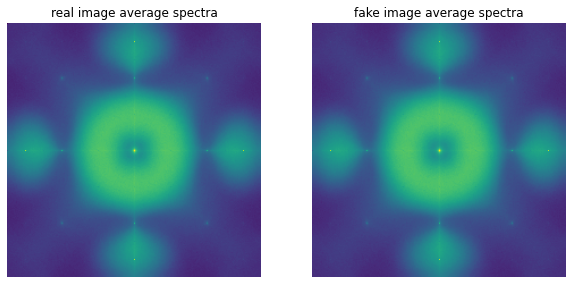

In [ ]:
#@title Attack Experiment L2C&W 1
from foolbox.attacks import L2CarliniWagnerAttack

attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.17774027784531654


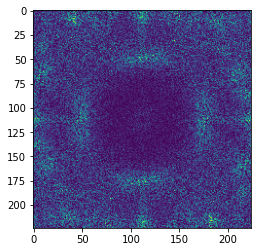

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 25/1600 [00:00<00:06, 243.48it/s]

L2 norm ≤ 2     :  0.1 %


100%|██████████| 1600/1600 [00:06<00:00, 247.08it/s]


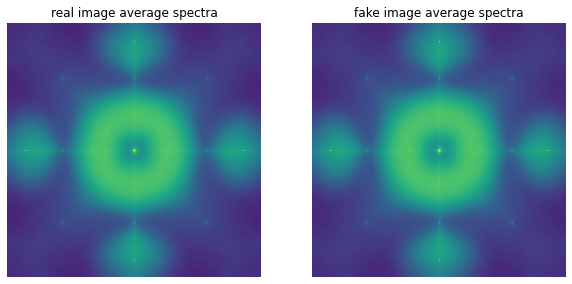

In [ ]:
#@title Attack Experiment L2C&W 2
from foolbox.attacks import L2CarliniWagnerAttack

attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [2]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.18450144741390062


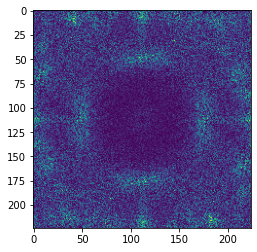

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 24/1600 [00:00<00:06, 239.45it/s]

L2 norm ≤ 5     :  0.1 %


100%|██████████| 1600/1600 [00:06<00:00, 246.18it/s]


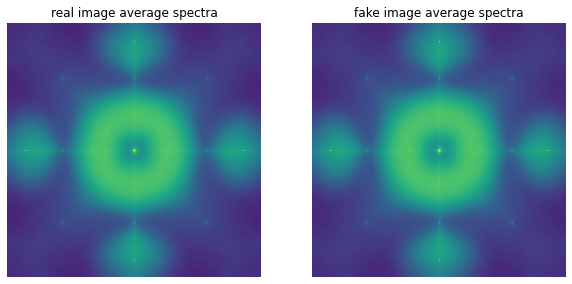

In [ ]:
#@title Attack Experiment L2C&W 5
from foolbox.attacks import L2CarliniWagnerAttack

attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [5]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra(clean_images)
adv_spectra = average_spectra(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.18445785757849364


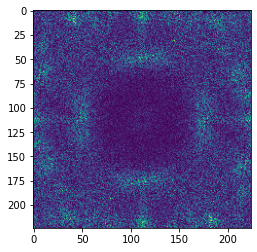

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  1%|▏         | 21/1600 [00:00<00:07, 198.51it/s]

L2 norm ≤ 0.1   : 14.2 %


100%|██████████| 1600/1600 [00:06<00:00, 264.29it/s]


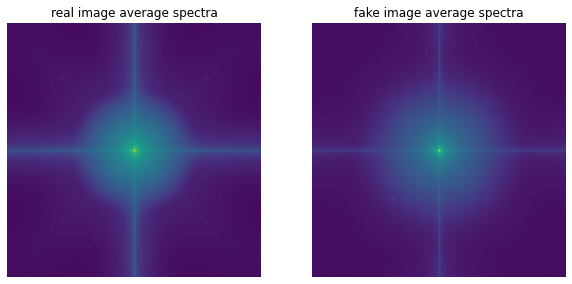

In [ ]:
#@title Attack Experiment LinfFGSM 0.1 Low Pass
from foolbox.attacks import LinfFastGradientAttack

attack = LinfFastGradientAttack()
epsilons = [0.1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra_low(clean_images)
adv_spectra = average_spectra_low(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

17.391977219102074


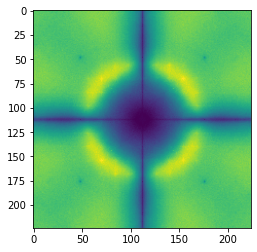

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 27/1600 [00:00<00:05, 267.67it/s]

L2 norm ≤ 2     :  1.1 %


100%|██████████| 1600/1600 [00:06<00:00, 258.15it/s]


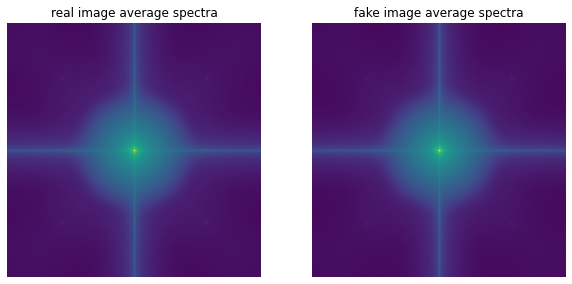

In [ ]:
#@title Attack Experiment L2PGD 2 Low Pass
attack = L2PGD()
epsilons = [2]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra_low(clean_images)
adv_spectra = average_spectra_low(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

1.1420547831601908


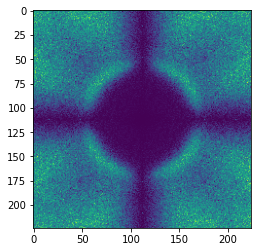

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  2%|▏         | 29/1600 [00:00<00:05, 284.52it/s]

L2 norm ≤ 1     :  2.1 %


100%|██████████| 1600/1600 [00:05<00:00, 294.13it/s]


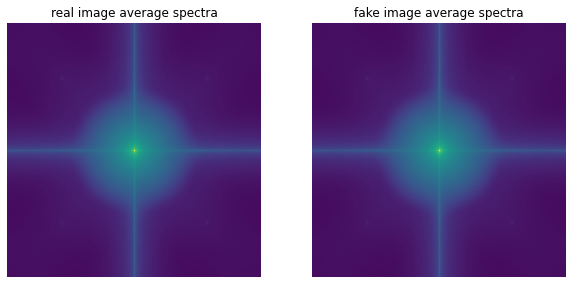

In [ ]:
#@title Attack Experiment L2C&W 1 Low Pass
from foolbox.attacks import L2CarliniWagnerAttack

attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['val'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra_low(clean_images)
adv_spectra = average_spectra_low(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.15449087045089982


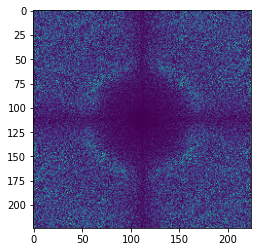

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  0%|          | 30/16000 [00:00<00:53, 296.11it/s]

L2 norm ≤ 0.5   : 18.4 %


100%|██████████| 16000/16000 [00:55<00:00, 289.29it/s]


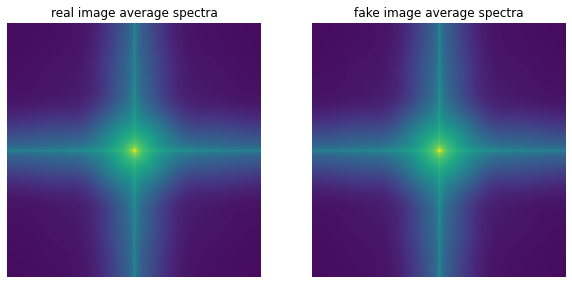

In [ ]:
#@title Attack Experiment L2PGD 0.5 No pass
attack = L2PGD()
epsilons = [0.5]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['train'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra_raw(clean_images)
adv_spectra = average_spectra_raw(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.0352749368255445


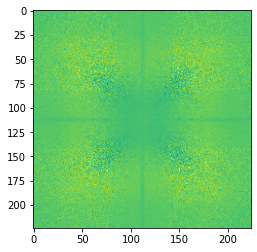

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  0%|          | 28/16000 [00:00<00:58, 274.02it/s]

L2 norm ≤ 1     : 18.4 %


100%|██████████| 16000/16000 [00:58<00:00, 275.67it/s]


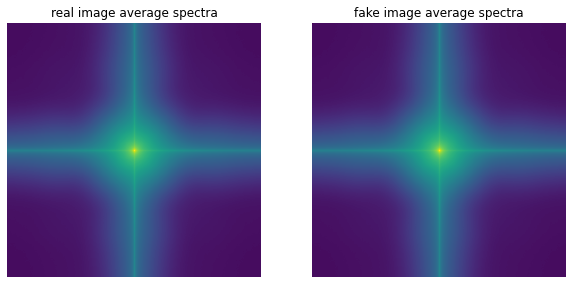

In [ ]:
#@title Attack Experiment L2CW 1 No pass
from foolbox.attacks import L2CarliniWagnerAttack

attack = L2CarliniWagnerAttack(steps=40, stepsize=0.0015)
epsilons = [1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['train'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra_raw(clean_images)
adv_spectra = average_spectra_raw(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

0.05628276441372293


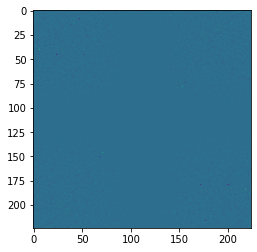

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)

  0%|          | 30/16000 [00:00<00:53, 298.35it/s]

L2 norm ≤ 0.1   :  2.5 %


100%|██████████| 16000/16000 [00:58<00:00, 273.21it/s]


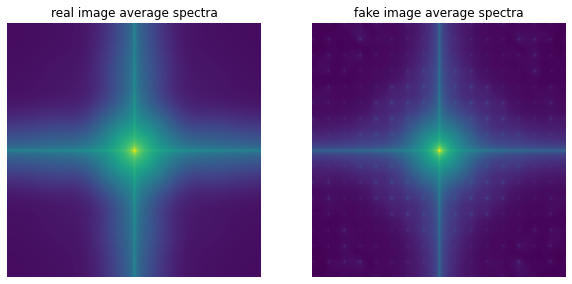

In [ ]:
#@title Attack Experiment LinfFGSM 0.1 No Pass
from foolbox.attacks import LinfFastGradientAttack

attack = LinfFastGradientAttack()
epsilons = [0.1]
count = 0
running_acc = torch.zeros(len(epsilons)).to(device)
clean_images = []
adv_images = []

with tqdm(dataloaders['train'], unit='batch') as tepoch:
  for inputs, labels in tepoch:
    inputs = inputs.to(device)
    labels = labels.to(device)
    raw_advs, clipped_advs, success = attack(fmodel, inputs, labels, epsilons=epsilons)
    for i in range(inputs.shape[0]):
      input = inputs[i].permute(1, 2, 0).cpu().numpy()
      adv = clipped_advs[0][i].permute(1, 2, 0).cpu().numpy()
      clean_images.append(input*255)
      adv_images.append(adv*255)

    running_acc += 1 - success.float().mean(axis=-1)
    count += 1
running_acc /= count

for eps, acc in zip(epsilons, running_acc):
    print(f"L2 norm ≤ {eps:<6}: {acc.item() * 100:4.1f} %")

clean_spectra = average_spectra_raw(clean_images)
adv_spectra = average_spectra_raw(adv_images)
fig, ax = plt.subplots(1,2, figsize=(10, 10))
for a in ax:
  a.set_axis_off()
ax[0].set_title('real image average spectra')
ax[0].imshow(clean_spectra)
ax[1].set_title('fake image average spectra')
ax[1].imshow(adv_spectra)

53.45584313549827


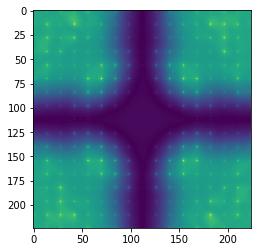

In [ ]:
diff = np.abs(adv_spectra-clean_spectra)
print(np.max(diff))
plt.imshow(diff)